100%|██████████| 79/79 [00:23<00:00,  3.35it/s]


test set accuracy is 0.958800


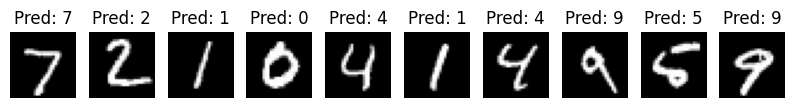

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from nanograd.nn import tensor
from nanograd.nn.tensor import Tensor
from tqdm import trange
import gzip, os
from nanograd.nn import optim
from nanograd.nn.helpers import getenv

def train(model, X_train, Y_train, optim, steps, BS=128, lossfn=lambda out,y: out.sparse_categorical_crossentropy(y),
        transform=lambda x: x, target_transform=lambda x: x, noloss=False):
    tensor.training = True
    losses, accuracies = [], []
    for i in (t := trange(steps, disable=getenv('CI', False))):
        samp = np.random.randint(0, X_train.shape[0], size=(BS))
        x = Tensor(transform(X_train[samp]), requires_grad=False)
        y = Tensor(target_transform(Y_train[samp]))

        # network
        out = model.forward(x) if hasattr(model, 'forward') else model(x)
        loss = lossfn(out, y)
        optim.zero_grad()
        loss.backward()
        if noloss: del loss
        optim.step()

        # printing
        if not noloss:
            cat = np.argmax(out.numpy(), axis=-1)
            accuracy = (cat == y.numpy()).mean()

            loss = loss.detach().numpy()
            losses.append(loss)
            accuracies.append(accuracy)
            t.set_description("loss %.2f accuracy %.2f" % (loss, accuracy))
    return [losses, accuracies]

def evaluate(model, X_test, Y_test, num_classes=None, BS=128, return_predict=False, transform=lambda x: x,
             target_transform=lambda y: y):
    tensor.training = False
    def numpy_eval(Y_test, num_classes):
        Y_test_preds_out = np.zeros(list(Y_test.shape)+[num_classes])
        for i in trange((len(Y_test)-1)//BS+1, disable=getenv('CI', False)):
            x = Tensor(transform(X_test[i*BS:(i+1)*BS]))
            out = model.forward(x) if hasattr(model, 'forward') else model(x)
            Y_test_preds_out[i*BS:(i+1)*BS] = out.numpy()
        Y_test_preds = np.argmax(Y_test_preds_out, axis=-1)
        Y_test = target_transform(Y_test)
        return (Y_test == Y_test_preds).mean(), Y_test_preds

    if num_classes is None: num_classes = Y_test.max().astype(int)+1
    acc, Y_test_pred = numpy_eval(Y_test, num_classes)
    print("test set accuracy is %f" % acc)
    
    if return_predict:
        return acc, Y_test_pred
    else:
        return acc

def fetch_mnist():
    parse = lambda file: np.frombuffer(gzip.open(file).read(), dtype=np.uint8).copy()
    X_train = parse("train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28*28)).astype(np.float32)
    Y_train = parse("train-labels-idx1-ubyte.gz")[8:]
    X_test = parse("t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28*28)).astype(np.float32)
    Y_test = parse("t10k-labels-idx1-ubyte.gz")[8:]
    return X_train, Y_train, X_test, Y_test

X_train, Y_train, X_test, Y_test = fetch_mnist()

class NanoConvNet:
    def __init__(self):
        conv = 3
        inter_chan, out_chan = 8, 16
        self.c1 = Tensor.scaled_uniform(inter_chan,1,conv,conv)
        self.c2 = Tensor.scaled_uniform(out_chan,inter_chan,conv,conv)
        self.l1 = Tensor.scaled_uniform(out_chan*5*5, 10)

    def forward(self, x:tensor):
        x = x.reshape(shape=(-1, 1, 28, 28))
        x = x.conv2d(self.c1).relu().max_pool2d()
        x = x.conv2d(self.c2).relu().max_pool2d()
        x = x.reshape(shape=[x.shape[0], -1])
        return x.dot(self.l1).log_softmax()

if __name__ == "__main__":
    np.random.seed(1337)
    model = NanoConvNet()
    optimizer = optim.Adam([model.c1, model.c2, model.l1], lr=0.001)
    train(model, X_train, Y_train, optimizer, steps=100)
    accuracy, Y_test_pred = evaluate(model, X_test, Y_test, return_predict=True)

    # Visualize some predictions
    num_images = 10
    X_test_images = X_test[:num_images].reshape(-1, 28, 28)
    Y_test_pred_images = Y_test_pred[:num_images]

    plt.figure(figsize=(10, 2))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(X_test_images[i], cmap="gray")
        plt.title(f"Pred: {Y_test_pred_images[i]}")
        plt.axis('off')
    plt.show()
